# Thesis

- Topic: Plant Disease detection
- Author: Antriksh Kumar Singh
- Batch: October 21 (C11)

---

### Importing Libraries an initial checks

In [1]:
#  Installing required libraries
# !pip install numpy tensorflow pandas matplotlib opencv-python tensorboard-plugin-profile
!pip list

Package                      Version
---------------------------- -----------
absl-py                      1.0.0
asttokens                    2.0.5
astunparse                   1.6.3
backcall                     0.2.0
black                        22.3.0
cachetools                   5.1.0
certifi                      2022.5.18.1
cfgv                         3.3.1
charset-normalizer           2.0.12
click                        8.1.3
colorama                     0.4.4
cycler                       0.11.0
debugpy                      1.6.0
decorator                    5.1.1
distlib                      0.3.4
entrypoints                  0.4
executing                    0.8.3
filelock                     3.4.2
flatbuffers                  1.12
fonttools                    4.33.3
gast                         0.4.0
google-auth                  2.6.6
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
grpcio                       1.46.3
gviz-api                     1.10.0
h5p

In [2]:
%load_ext tensorboard

In [3]:
# Clear any logs from previous runs
!rm -rf "./logs/"

In [4]:
# Importing all required libraries
import os
import pathlib as pl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

from mbp import ModelBuilderPipeline as mb

In [5]:
# Check if GPU is recognized
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---

### Importing Data

In [6]:
# Defining base paths
CWD = os.getcwd()
DATA_PATH = "./data"
ABS_DATA_PATH = os.path.join(CWD,DATA_PATH)
plant_village = pl.Path(ABS_DATA_PATH)

In [7]:
# Initialization global vars
batch_size = 16
img_height = 256
img_width = 256
seed = 123
channels = 3

In [8]:
# Loading the plant village dataset
pv = tf.keras.utils.image_dataset_from_directory(
  plant_village,
  batch_size=batch_size,
  image_size=(img_height,img_width),
  shuffle=True,
  seed=seed
)

Found 21840 files belonging to 23 classes.


In [9]:
# Dataset summary
pv

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
# Plant Classes summary
all_classes = pv.class_names
all_images = list(plant_village.glob("*/*.jpg"))
all_classes_count = len(all_classes)
all_images_count = len(all_images)
print(f"Dataset have {all_classes_count} classes in total with {all_images_count} images\n")
print(all_classes)

Dataset have 23 classes in total with 21839 images

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Strawberry___Leaf_scorch', 'Strawberry___healthy']


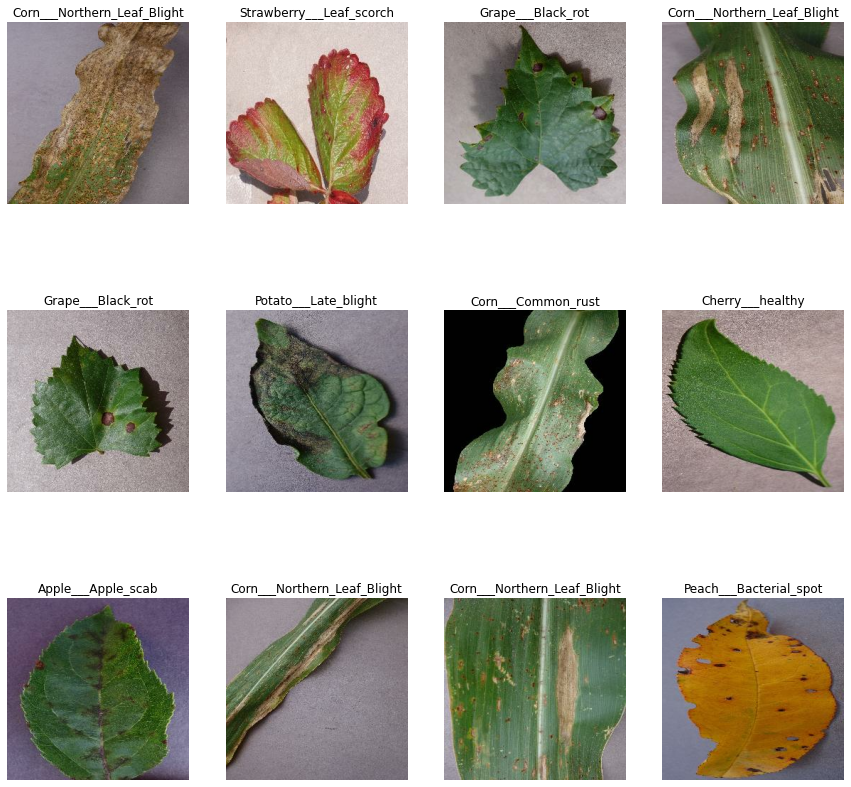

In [11]:
# Plotting random images the dataset batch
plt.figure(figsize = (15,15))
for image, label in pv.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1) # many plots at a time => subplots
        plt.imshow(image[i].numpy().astype('uint8')) #converting all data of image into numpy and than to integer type as they were in float.
        plt.title(all_classes[label[i]])  # title of the class_name of image
        plt.axis("off") # Hide the values of graph

---

### EDA

In [12]:
# Analyzing dataset
processed_labels = []
for _class in all_classes:
  if _class != "Background_without_leaves":
    l = _class.split('___')
    l.append(_class)
    processed_labels.append(l)

class_df = pd.DataFrame(processed_labels,columns=["plant","label","folder"])
class_df["abs_path"] = class_df["folder"].apply(lambda x: plant_village.joinpath(x))
class_df["images"] = class_df["abs_path"].apply(lambda x: len(os.listdir(x)))
class_df["is_healthy"] = class_df["label"]=="healthy"
class_df

,plant,label,folder,abs_path,images,is_healthy
0,Apple,Apple_scab,Apple___Apple_scab,d:\projects\masters\masters\Final Report\Code\...,630,False
1,Apple,Black_rot,Apple___Black_rot,d:\projects\masters\masters\Final Report\Code\...,621,False
2,Apple,Cedar_apple_rust,Apple___Cedar_apple_rust,d:\projects\masters\masters\Final Report\Code\...,275,False
3,Apple,healthy,Apple___healthy,d:\projects\masters\masters\Final Report\Code\...,1645,True
4,Cherry,Powdery_mildew,Cherry___Powdery_mildew,d:\projects\masters\masters\Final Report\Code\...,1052,False
5,Cherry,healthy,Cherry___healthy,d:\projects\masters\masters\Final Report\Code\...,854,True
6,Corn,Cercospora_leaf_spot Gray_leaf_spot,Corn___Cercospora_leaf_spot Gray_leaf_spot,d:\projects\masters\masters\Final Report\Code\...,513,False
7,Corn,Common_rust,Corn___Common_rust,d:\projects\masters\masters\Final Report\Code\...,1192,False
8,Corn,Northern_Leaf_Blight,Corn___Northern_Leaf_Blight,d:\projects\masters\masters\Final Report\Code\...,985,False
9,Corn,healthy,Corn___healthy,d:\projects\masters\masters\Final Report\Code\...,1162,True


In [13]:
# Total types of plants covered
all_plants = class_df["plant"].unique()
print(f"Plant village has images from {len(all_plants)} type of plants")

Plant village has images from 8 type of plants


In [14]:
# Summarizing dataset for binary classification at dataset level
health_summary = class_df.groupby('is_healthy').sum()
health_summary["ratio"]=health_summary["images"]/all_images_count
health_summary

,images,ratio
is_healthy,,
False,15310,0.701039
True,6530,0.299006


In [15]:
# Summarizing dataset for binary classification at plant level
pl_health_summary = class_df.groupby(['plant','is_healthy']).sum()
pl_health_summary

images
plant        is_healthy        
Apple        False         1526
             True          1645
Cherry       False         1052
             True           854
Corn         False         2690
             True          1162
Grape        False         3639
             True           423
Peach        False         2297
             True           360
Pepper,_bell False          997
             True          1478
Potato       False         2000
             True           152
Strawberry   False         1109
             True           456

---

### Test Train Split

In [16]:
# Function for Splitting the data
def split_dataset(ds, train_split=0.6, val_split=0.2, test_split=0.2, shuffle=True, shuffle_size=100):
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = seed)

  ds_size = len(ds)
  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, test_ds, val_ds

In [17]:
train_ds, test_ds, val_ds = split_dataset(pv)

In [18]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)

---

### Image Preprocessing

In [19]:
# Initialization global vars
batch_size = 16
img_height = 256
img_width = 256
seed = 123
channels = 3

res_img_height = 256
res_img_width = 256

In [20]:
input_shape = (img_height, img_width, channels)

In [21]:
# Image Preprocessing : Rescaling and Resizing
resize = tf.keras.Sequential([
    layers.Resizing(res_img_height, res_img_width,input_shape=input_shape)
])
rescale = tf.keras.Sequential([
    layers.Rescaling(1.0/255)
])

In [22]:
# Data augmentation by flipping and rotating existing images
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip(mode="horizontal_and_vertical"),
    layers.RandomRotation(factor = 0.5)
])

---

### Model Building

Model building pipelines is simplified in `mbp.py`

##### Model 1 : From Scratch CNN

👉 Building and compiling...
Total Parameter 4219447


👉 Fitting the model...
Epoch 1/10
819/819 [==============================] - 49s 58ms/step - loss: 6.9447 - accuracy: 0.3559 - val_loss: 1.5895 - val_accuracy: 0.5410
Epoch 2/10
819/819 [==============================] - 55s 67ms/step - loss: 1.1331 - accuracy: 0.6654 - val_loss: 0.9177 - val_accuracy: 0.7317
Epoch 3/10
819/819 [==============================] - 81s 99ms/step - loss: 0.5261 - accuracy: 0.8373 - val_loss: 0.8938 - val_accuracy: 0.7507
Epoch 4/10
819/819 [==============================] - 75s 92ms/step - loss: 0.3333 - accuracy: 0.8949 - val_loss: 0.7827 - val_accuracy: 0.8086
Epoch 5/10
819/819 [==============================] - 75s 91ms/step - loss: 0.2212 - accuracy: 0.9267 - val_loss: 0.9175 - val_accuracy: 0.8102
Epoch 6/10
819/819 [==============================] - 64s 79ms/step - loss: 0.1719 - accuracy: 0.9461 - val_loss: 1.1051 - val_accuracy: 0.7990
Epoch 7/10
819/819 [==============================] - 67s 8

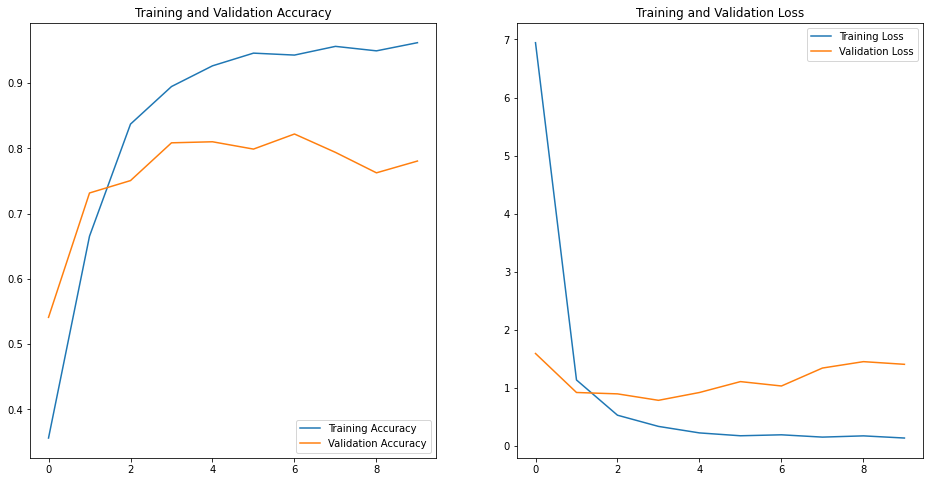

In [24]:
m1 = mb(
    model=tf.keras.models.Sequential(
        [
            resize,
            layers.Conv2D(16, 3, padding="same", activation="relu"),
            layers.MaxPooling2D(),
            layers.Conv2D(32, 3, padding="same", activation="relu"),
            layers.MaxPooling2D(),
            layers.Conv2D(64, 3, padding="same", activation="relu"),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(64, activation="relu"),
            layers.Dense(all_classes_count, activation="softmax"),
        ]
    ),
    input_shape=input_shape,
)

m1.run(tds=train_ds, vds=val_ds, ttds=test_ds)


##### Model 2 : With augmentation

👉 Building and compiling...
Total Parameter 4219447


👉 Fitting the model...
Epoch 1/10
819/819 [==============================] - 95s 115ms/step - loss: 4.5027 - accuracy: 0.3164 - val_loss: 1.8131 - val_accuracy: 0.4350
Epoch 2/10
819/819 [==============================] - 79s 97ms/step - loss: 1.6403 - accuracy: 0.4859 - val_loss: 1.3886 - val_accuracy: 0.5772
Epoch 3/10
819/819 [==============================] - 92s 112ms/step - loss: 1.2465 - accuracy: 0.6074 - val_loss: 1.2937 - val_accuracy: 0.6051
Epoch 4/10
819/819 [==============================] - 88s 107ms/step - loss: 0.9972 - accuracy: 0.6778 - val_loss: 1.2101 - val_accuracy: 0.6632
Epoch 5/10
819/819 [==============================] - 84s 103ms/step - loss: 0.8119 - accuracy: 0.7389 - val_loss: 1.4323 - val_accuracy: 0.6124
Epoch 6/10
819/819 [==============================] - 89s 109ms/step - loss: 0.7703 - accuracy: 0.7532 - val_loss: 0.9220 - val_accuracy: 0.7365
Epoch 7/10
819/819 [==============================] - 

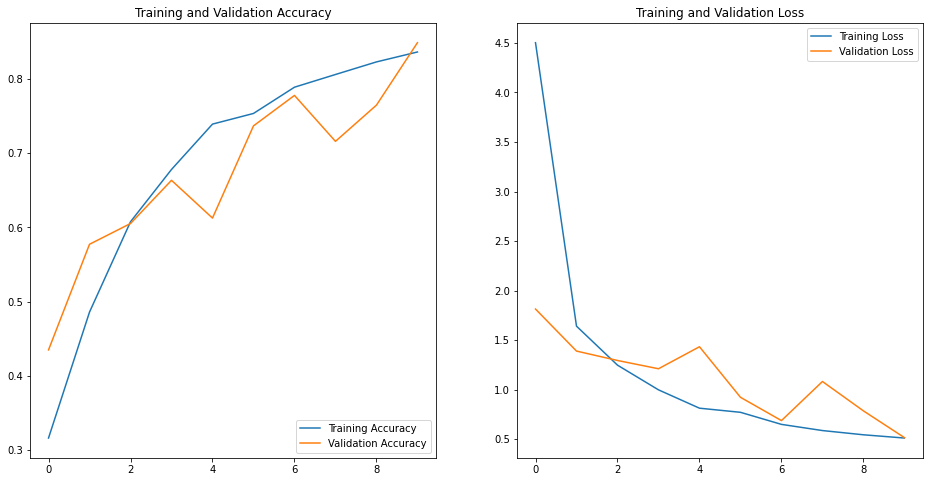

In [25]:
m2 = mb(
    model=tf.keras.models.Sequential(
        [
            resize,
            rescale,
            data_augmentation,
            layers.Conv2D(16, 3, padding="same", activation="relu"),
            layers.MaxPooling2D(),
            layers.Conv2D(32, 3, padding="same", activation="relu"),
            layers.MaxPooling2D(),
            layers.Conv2D(64, 3, padding="same", activation="relu"),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(64, activation="relu"),
            layers.Dense(all_classes_count, activation="softmax"),
        ]
    ),
    input_shape=input_shape,
)

m2.run(tds=train_ds, vds=val_ds, ttds=test_ds)


##### Model 3 : With  batch normalization

👉 Building and compiling...
Total Parameter 4219511


👉 Fitting the model...
Epoch 1/10
819/819 [==============================] - 92s 111ms/step - loss: 1.8267 - accuracy: 0.4849 - val_loss: 1.4097 - val_accuracy: 0.6197
Epoch 2/10
819/819 [==============================] - 74s 90ms/step - loss: 0.8583 - accuracy: 0.7281 - val_loss: 0.7889 - val_accuracy: 0.7541
Epoch 3/10
819/819 [==============================] - 82s 101ms/step - loss: 0.6141 - accuracy: 0.8039 - val_loss: 0.9259 - val_accuracy: 0.7379
Epoch 4/10
819/819 [==============================] - 82s 100ms/step - loss: 0.4923 - accuracy: 0.8426 - val_loss: 0.5385 - val_accuracy: 0.8299
Epoch 5/10
819/819 [==============================] - 71s 87ms/step - loss: 0.3971 - accuracy: 0.8678 - val_loss: 0.5518 - val_accuracy: 0.8249
Epoch 6/10
819/819 [==============================] - 79s 96ms/step - loss: 0.3349 - accuracy: 0.8906 - val_loss: 0.4481 - val_accuracy: 0.8544
Epoch 7/10
819/819 [==============================] - 72

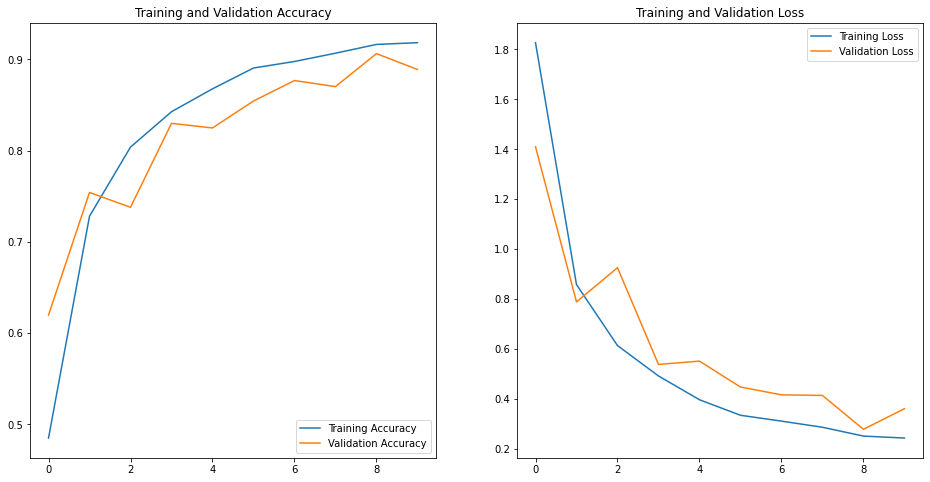

In [26]:
m3 = mb(
    model=tf.keras.models.Sequential(
        [
            resize,
            rescale,
            data_augmentation,
            layers.Conv2D(16, 3, padding="same", activation="relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(32, 3, padding="same", activation="relu"),
            layers.MaxPooling2D(),
            layers.Conv2D(64, 3, padding="same", activation="relu"),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(64, activation="relu"),
            layers.Dense(all_classes_count, activation="softmax"),
        ]
    ),
    input_shape=input_shape,
)

m3.run(tds=train_ds, vds=val_ds, ttds=test_ds)


##### Model 4 : With Dropouts

👉 Building and compiling...
Total Parameter 4219447


👉 Fitting the model...
Epoch 1/10
819/819 [==============================] - 100s 120ms/step - loss: 4.5281 - accuracy: 0.2885 - val_loss: 1.9838 - val_accuracy: 0.4048
Epoch 2/10
819/819 [==============================] - 78s 95ms/step - loss: 1.6006 - accuracy: 0.4993 - val_loss: 1.2795 - val_accuracy: 0.5978
Epoch 3/10
819/819 [==============================] - 77s 94ms/step - loss: 1.0856 - accuracy: 0.6493 - val_loss: 1.0119 - val_accuracy: 0.6777
Epoch 4/10
819/819 [==============================] - 76s 93ms/step - loss: 0.8436 - accuracy: 0.7266 - val_loss: 0.7429 - val_accuracy: 0.7619
Epoch 5/10
819/819 [==============================] - 76s 92ms/step - loss: 0.6843 - accuracy: 0.7776 - val_loss: 0.8459 - val_accuracy: 0.7280
Epoch 6/10
819/819 [==============================] - 80s 98ms/step - loss: 0.6490 - accuracy: 0.7861 - val_loss: 0.5684 - val_accuracy: 0.8125
Epoch 7/10
819/819 [==============================] - 78s

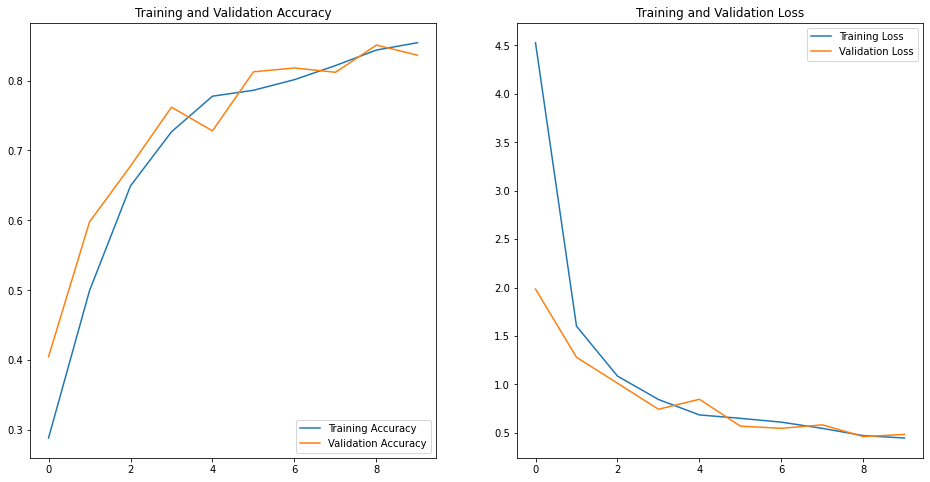

In [27]:
m4 = mb(
    model=tf.keras.models.Sequential(
        [
            resize,
            rescale,
            data_augmentation,
            layers.Conv2D(16, 3, padding="same", activation="relu"),
            layers.MaxPooling2D(),
            layers.Conv2D(32, 3, padding="same", activation="relu"),
            layers.MaxPooling2D(),
            layers.Conv2D(64, 3, padding="same", activation="relu"),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dropout(0.1),
            layers.Dense(64, activation="relu"),
            layers.Dense(all_classes_count, activation="softmax"),
        ]
    ),
    input_shape=input_shape,
)

m4.run(tds=train_ds, vds=val_ds, ttds=test_ds)


##### Model T1 : With Transfer Learning Xception

##### Model T2 : With Transfer Learning Xception

In [26]:
# Load the state of the art
xception = tf.keras.applications.Xception(
    weights="imagenet", input_shape=input_shape, include_top=False
)
# Freeze params
xception.trainable = False

inputs = tf.keras.Input(shape=input_shape)
x = resize(inputs)
x = layers.Rescaling(scale=1 / 127.5, offset=-1)(x)
# x = data_augmentation(x)
x = xception(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(all_classes_count, activation="softmax")(x)

mt2 = mb(model=tf.keras.Model(inputs, outputs), input_shape=input_shape)


👉 Building and compiling...
Total Parameter 20908607


In [27]:
mt2.model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                           



👉 Fitting the model...
Epoch 1/8
819/819 [==============================] - 126s 149ms/step - loss: 0.6204 - accuracy: 0.8422 - val_loss: 0.2690 - val_accuracy: 0.9267
Epoch 2/8
819/819 [==============================] - 103s 126ms/step - loss: 0.2196 - accuracy: 0.9408 - val_loss: 0.1792 - val_accuracy: 0.9485
Epoch 3/8
819/819 [==============================] - 139s 169ms/step - loss: 0.1554 - accuracy: 0.9573 - val_loss: 0.1430 - val_accuracy: 0.9563
Epoch 4/8
819/819 [==============================] - 121s 147ms/step - loss: 0.1214 - accuracy: 0.9681 - val_loss: 0.1350 - val_accuracy: 0.9560
Epoch 5/8
819/819 [==============================] - 93s 114ms/step - loss: 0.1017 - accuracy: 0.9699 - val_loss: 0.1180 - val_accuracy: 0.9613
Epoch 6/8
819/819 [==============================] - 155s 189ms/step - loss: 0.0840 - accuracy: 0.9771 - val_loss: 0.1084 - val_accuracy: 0.9645
Epoch 7/8
819/819 [==============================] - 139s 170ms/step - loss: 0.0752 - accuracy: 0.9781 - v

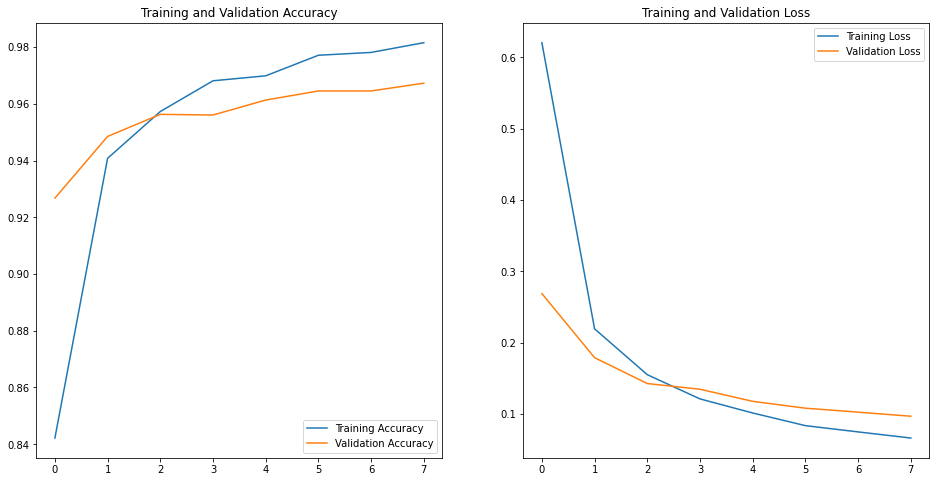

In [28]:
mt2.run(tds=train_ds, vds=val_ds, ttds=test_ds)

##### Model T3 : With Transfer Learning ResNet

In [23]:
# Load the state of the art
resnet = tf.keras.applications.ResNet50V2(
    weights="imagenet", input_shape=input_shape, include_top=False
)
# Freeze params
resnet.trainable = False

inputs = tf.keras.Input(shape=input_shape)
x = resize(inputs)
x = layers.Rescaling(scale=1 / 127.5, offset=-1)(x)
# x = data_augmentation(x)
x = resnet(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(all_classes_count, activation="softmax")(x)

mt3 = mb(model=tf.keras.Model(inputs, outputs), input_shape=input_shape)

👉 Building and compiling...
Total Parameter 23611927




👉 Fitting the model...
Epoch 1/10
819/819 [==============================] - 300s 319ms/step - loss: 0.3965 - accuracy: 0.8929 - val_loss: 0.1469 - val_accuracy: 0.9531
Epoch 2/10
819/819 [==============================] - 124s 151ms/step - loss: 0.1097 - accuracy: 0.9679 - val_loss: 0.0890 - val_accuracy: 0.9718
Epoch 3/10
819/819 [==============================] - 129s 157ms/step - loss: 0.0745 - accuracy: 0.9779 - val_loss: 0.0763 - val_accuracy: 0.9762
Epoch 4/10
819/819 [==============================] - 149s 182ms/step - loss: 0.0557 - accuracy: 0.9837 - val_loss: 0.0715 - val_accuracy: 0.9762
Epoch 5/10
819/819 [==============================] - 124s 152ms/step - loss: 0.0455 - accuracy: 0.9856 - val_loss: 0.0800 - val_accuracy: 0.9760
Epoch 6/10
819/819 [==============================] - 126s 153ms/step - loss: 0.0419 - accuracy: 0.9874 - val_loss: 0.0731 - val_accuracy: 0.9766
Epoch 7/10
819/819 [==============================] - 140s 171ms/step - loss: 0.0324 - accuracy: 0.

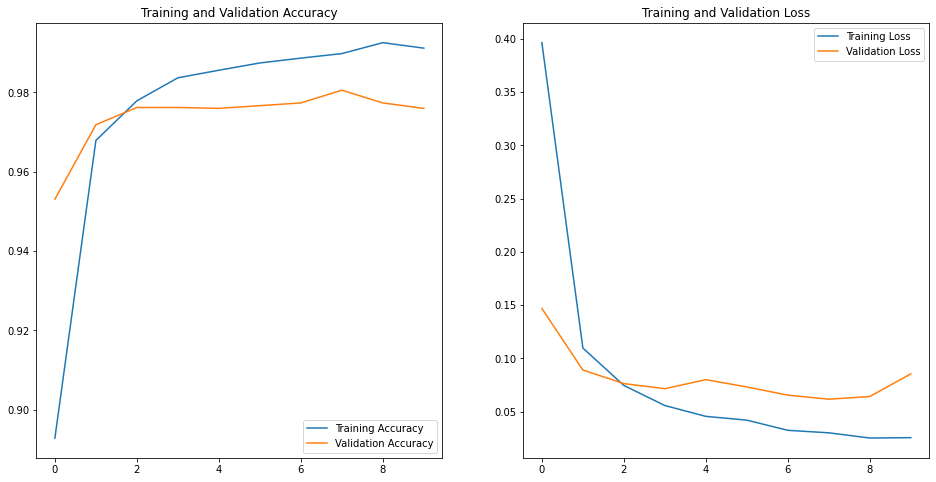

In [25]:
mt3.run(tds=train_ds, vds=val_ds, ttds=test_ds)

##### Model T4 : With Transfer Learning Inception

In [26]:
# Load the state of the art
inception = tf.keras.applications.InceptionV3(
    weights="imagenet", input_shape=input_shape, include_top=False
)
# Freeze params
inception.trainable = False

inputs = tf.keras.Input(shape=input_shape)
x = resize(inputs)
x = layers.Rescaling(scale=1 / 127.5, offset=-1)(x)
# x = data_augmentation(x)
x = inception(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(all_classes_count, activation="softmax")(x)

mt4 = mb(model=tf.keras.Model(inputs, outputs), input_shape=input_shape)

87910968/87910968 [==============================] - 7s 0us/step
👉 Building and compiling...
Total Parameter 21849911


In [27]:
mt4.model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                           



👉 Fitting the model...
Epoch 1/10
819/819 [==============================] - 109s 127ms/step - loss: 0.6052 - accuracy: 0.8355 - val_loss: 0.2588 - val_accuracy: 0.9281
Epoch 2/10
819/819 [==============================] - 96s 117ms/step - loss: 0.2118 - accuracy: 0.9370 - val_loss: 0.1740 - val_accuracy: 0.9473
Epoch 3/10
819/819 [==============================] - 93s 113ms/step - loss: 0.1475 - accuracy: 0.9540 - val_loss: 0.1777 - val_accuracy: 0.9444
Epoch 4/10
819/819 [==============================] - 92s 113ms/step - loss: 0.1207 - accuracy: 0.9615 - val_loss: 0.1678 - val_accuracy: 0.9441
Epoch 5/10
819/819 [==============================] - 93s 114ms/step - loss: 0.0920 - accuracy: 0.9721 - val_loss: 0.1276 - val_accuracy: 0.9613
Epoch 6/10
819/819 [==============================] - 98s 120ms/step - loss: 0.0786 - accuracy: 0.9750 - val_loss: 0.1391 - val_accuracy: 0.9592
Epoch 7/10
819/819 [==============================] - 80s 98ms/step - loss: 0.0731 - accuracy: 0.9765 - 

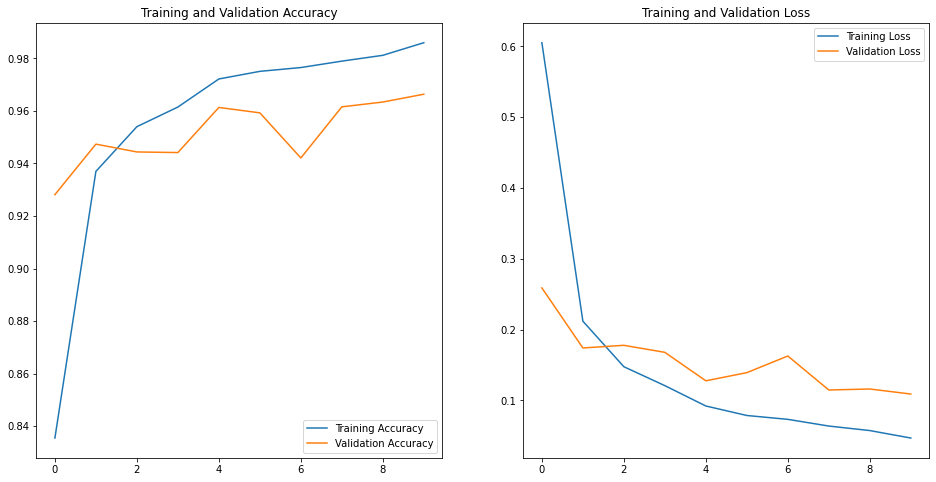

In [28]:
mt4.run(tds=train_ds, vds=val_ds, ttds=test_ds)

##### Model T5 : With Transfer Learning MobileNet

In [30]:
# Load the state of the art
mobilenet = tf.keras.applications.MobileNetV3Small(
    weights="imagenet", include_top=False
)
# Freeze params
mobilenet.trainable = False

inputs = tf.keras.Input(shape=input_shape)
x = resize(inputs)
x = layers.Rescaling(scale=1 / 127.5, offset=-1)(x)
# x = data_augmentation(x)
x = mobilenet(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(all_classes_count, activation="softmax")(x)

mt5 = mb(model=tf.keras.Model(inputs, outputs), input_shape=input_shape)

👉 Building and compiling...
Total Parameter 952391


In [31]:
mt5.model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, None, None, 576)  939120    
 l)                                                              
                                                                 
 global_average_pooling2d_3   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 576)               0   

In [32]:
mt5.run(tds=train_ds, vds=val_ds, ttds=test_ds)



👉 Fitting the model...
Epoch 1/10
819/819 [==============================] - 800s 970ms/step - loss: 2.8673 - accuracy: 0.1637 - val_loss: 2.7243 - val_accuracy: 0.2326
Epoch 2/10
819/819 [==============================] - ETA: 0s - loss: 2.6391 - accuracy: 0.2386

KeyboardInterrupt: 

##### Model T6 : With Transfer Learning DenseNet

In [23]:
# Load the state of the art
densenet = tf.keras.applications.DenseNet121(
    weights="imagenet", input_shape=input_shape, include_top=False
)
# Freeze params
densenet.trainable = False

inputs = tf.keras.Input(shape=input_shape)
x = resize(inputs)
x = layers.Rescaling(scale=1 / 127.5, offset=-1)(x)
# x = data_augmentation(x)
x = densenet(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(all_classes_count, activation="softmax")(x)

mt6 = mb(model=tf.keras.Model(inputs, outputs), input_shape=input_shape)

👉 Building and compiling...
Total Parameter 7061079


In [24]:
mt6.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                             



👉 Fitting the model...
Epoch 1/10
819/819 [==============================] - 314s 334ms/step - loss: 0.5794 - accuracy: 0.8600 - val_loss: 0.1703 - val_accuracy: 0.9629
Epoch 2/10
819/819 [==============================] - 146s 178ms/step - loss: 0.1412 - accuracy: 0.9668 - val_loss: 0.1080 - val_accuracy: 0.9714
Epoch 3/10
819/819 [==============================] - 145s 177ms/step - loss: 0.0924 - accuracy: 0.9766 - val_loss: 0.0841 - val_accuracy: 0.9746
Epoch 4/10
819/819 [==============================] - 161s 196ms/step - loss: 0.0769 - accuracy: 0.9793 - val_loss: 0.0691 - val_accuracy: 0.9812
Epoch 5/10
819/819 [==============================] - 140s 171ms/step - loss: 0.0592 - accuracy: 0.9836 - val_loss: 0.0534 - val_accuracy: 0.9837
Epoch 6/10
819/819 [==============================] - 148s 181ms/step - loss: 0.0515 - accuracy: 0.9858 - val_loss: 0.0572 - val_accuracy: 0.9819
Epoch 7/10
819/819 [==============================] - 219s 268ms/step - loss: 0.0454 - accuracy: 0.

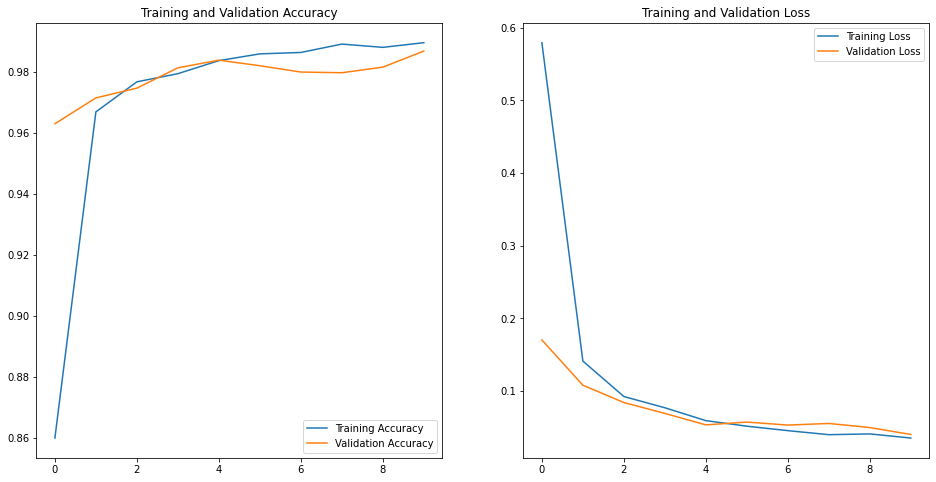

In [25]:
mt6.run(tds=train_ds, vds=val_ds, ttds=test_ds)

##### Model T7 : With Transfer Learning EfficientNet

In [23]:
# Load the state of the art
efficientnet = tf.keras.applications.EfficientNetV2S(
    weights="imagenet", input_shape=input_shape, include_top=False
)
# Freeze params
efficientnet.trainable = False

inputs = tf.keras.Input(shape=input_shape)
x = resize(inputs)
x = layers.Rescaling(scale=1 / 127.5, offset=-1)(x)
# x = data_augmentation(x)
x = efficientnet(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(all_classes_count, activation="softmax")(x)

mt7 = mb(model=tf.keras.Model(inputs, outputs), input_shape=input_shape)

👉 Building and compiling...
Total Parameter 20360823


In [24]:
mt7.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 8, 8, 1280)       20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0     



👉 Fitting the model...
Epoch 1/10
819/819 [==============================] - 303s 321ms/step - loss: 1.8332 - accuracy: 0.4701 - val_loss: 1.4084 - val_accuracy: 0.6069
Epoch 2/10
819/819 [==============================] - 123s 151ms/step - loss: 1.2970 - accuracy: 0.6176 - val_loss: 1.1910 - val_accuracy: 0.6573
Epoch 3/10
819/819 [==============================] - 109s 133ms/step - loss: 1.1289 - accuracy: 0.6615 - val_loss: 983.1496 - val_accuracy: 0.6889
Epoch 4/10
819/819 [==============================] - 110s 135ms/step - loss: 1.0312 - accuracy: 0.6888 - val_loss: 0.9888 - val_accuracy: 0.7054
Epoch 5/10
819/819 [==============================] - 138s 168ms/step - loss: 0.9642 - accuracy: 0.7061 - val_loss: 0.9278 - val_accuracy: 0.7264
Epoch 6/10
819/819 [==============================] - 127s 155ms/step - loss: 848.7736 - accuracy: 0.7189 - val_loss: 0.8929 - val_accuracy: 0.7376
Epoch 7/10
819/819 [==============================] - 127s 155ms/step - loss: 0.8735 - accuracy

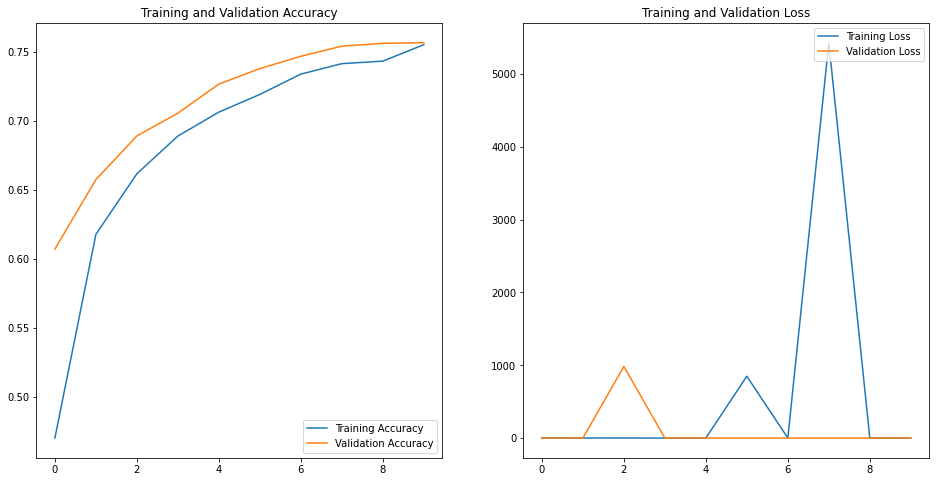

In [25]:
mt7.run(tds=train_ds, vds=val_ds, ttds=test_ds)

---

### Model Export

---

### Model Evaluation

---

### Conclusion

---